#### Exploring the omniglot dataset
https://github.com/brendenlake/omniglot/

In [3]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from load_images import load_images

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading our data
Let's load the dataset we're going to use. We'll be using the same 1 shot dataset used by brendenlake's example.  
load_images returns a list of "Dataset" objects, which hold our training and test data for a single run.  
Let's print the first 6 digits in our first run's training set!

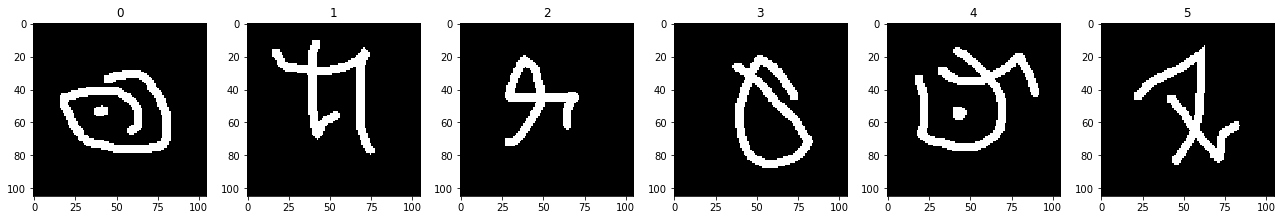

In [4]:
all_runs = load_images('all_runs')
run0 = all_runs[0]

fig = plt.figure(figsize=(18, 18))
for i in range(0, 6):
    ax = plt.subplot(1, 6, i+1)
    plt.tight_layout()
    
    ax.set_title(str(run0.train_y[i]))
    ax.imshow(run0.train_X[i].reshape(105, 105), cmap='gray')
plt.show()

Now I'll make sure the test set matches up to the training set.

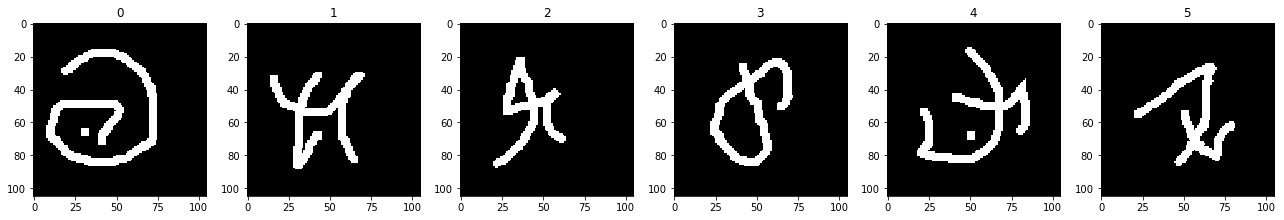

In [5]:
fig = plt.figure(figsize=(18, 18))

test_y_sorted = np.argsort(run0.test_y)

for i in range(0, 6):
    ax = plt.subplot(1, 6, i+1)
    plt.tight_layout()
    
    ax.set_title(str(run0.train_y[i]))
    ax.imshow(run0.test_X[test_y_sorted[i]].reshape(105, 105), cmap='gray')
plt.show()

Looks like we've successfully loaded our data! Now on to the hard part.

#### Exploring a simple CNN
I know this won't work, but it's an interesting starting point.  
Here I'll be defining an absolutely unecessarily large CNN which will never ever be able to predict properly but whatever. Lots of filters because we're predicting on lots of classes. This classifier is going to overfit absolutely disgustingly. Let's have a look!

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same', 
                 activation ='relu', input_shape = (105,105,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation = "softmax"))

In [8]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 250
batch_size = 4

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(run0.train_X)

In [10]:
history = model.fit_generator(datagen.flow(run0.train_X,run0.train_y_cat, batch_size=batch_size),
                              epochs = epochs, validation_data = (run0.test_X,run0.test_y_cat),
                              verbose = 0, steps_per_epoch=run0.train_X.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 00005: reducing learning rate to 0.000500000023749.

Epoch 00008: reducing learning rate to 0.000250000011874.

Epoch 00011: reducing learning rate to 0.000125000005937.

Epoch 00017: reducing learning rate to 6.25000029686e-05.

Epoch 00020: reducing learning rate to 3.12500014843e-05.

Epoch 00023: reducing learning rate to 1.56250007421e-05.

Epoch 00026: reducing learning rate to 1e-05.


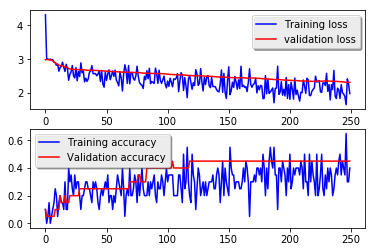

In [11]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Didn't really overfit like I expected, it just didn't work in general.

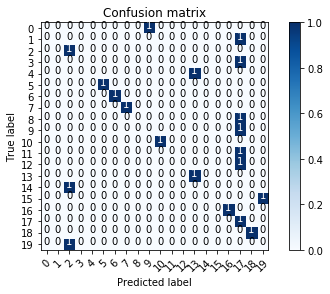

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(run0.test_X)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = run0.test_y
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(0, 20)) 

#### Real 